The models being compared will be: SGPR (VFE), FITC, PIC and PITC.

In [2]:
import GPflow.gpflow as gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from GPflow.gpflow.config import default_float
from GPflow.gpflow import set_trainable
from GPflow.gpflow.models import maximum_log_likelihood_objective, training_loss_closure
from GPflow.gpflow.ci_utils import ci_niter

In [3]:
def plot(model, color, ax):
    xx = np.linspace(-1, 11, 100)[:, None]
    mu, var = model.predict_y(xx)
    ax.plot(xx, mu, color, lw=2)
    ax.fill_between(
        xx[:, 0],
        mu[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mu[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color=color,
        alpha=0.2,
    )
    ax.plot(X, Y, "kx", mew=2)
    ax.set_xlim(-1, 11)

2022-08-14 16:57:15.531405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-14 16:57:15.531434: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-14 16:57:15.531453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jaime-XPS-13-7390): /proc/driver/nvidia/version does not exist
2022-08-14 16:57:15.531736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


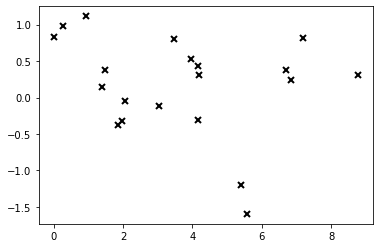

In [4]:
np.random.seed(1)
X = np.random.rand(20, 1) * 10
Y = np.sin(X) + 0.9 * np.cos(X * 1.6) + np.random.randn(*X.shape) * 0.4
Xtest = np.random.rand(10, 1) * 10
_ = plt.plot(X, Y, "kx", mew=2)

data = (
    tf.convert_to_tensor(X, dtype=default_float()),
    tf.convert_to_tensor(Y, dtype=default_float()),
)
inducing_variable = tf.convert_to_tensor(X, dtype=default_float())

In [10]:
m1 = gpflow.models.GPR(data, kernel=gpflow.kernels.SquaredExponential())

m2 = gpflow.models.SGPR(
    data, kernel=gpflow.kernels.SquaredExponential(), inducing_variable=inducing_variable
)
set_trainable(m2.inducing_variable, False)

m3 = gpflow.models.GPRFITC(
    data, kernel=gpflow.kernels.SquaredExponential(), inducing_variable=inducing_variable
)
set_trainable(m3.inducing_variable, False)

m4 = gpflow.models.GPRPITC(
    data, kernel=gpflow.kernels.SquaredExponential(), inducing_variable=inducing_variable
)
set_trainable(m4.inducing_variable, False)

models = [m1,m2,m3, m4]

for m in models:
    opt = gpflow.optimizers.Scipy()
    loss_closure = training_loss_closure(m, data)
    print(m.trainable_variables)
    opt.minimize(
        loss_closure,
        variables=m.trainable_variables,
        options=dict(maxiter=ci_niter(1000)),
        compile=True,
    )

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413232726357509>)
(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413232726357509>)
(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413232726357509>)


In [1]:
f, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 9))
plot(m1, "C0", ax[0, 0])
plot(m2, "C1", ax[1, 0])
plot(m3, "C2", ax[0, 1])
plot(m4, "C3", ax[1, 1])

NameError: name 'plt' is not defined